# Example: Geometric Brownian Motion (GBM) Simulation of Historical Price Data

## Background
[Geometric Brownian motion (GBM)](https://en.wikipedia.org/wiki/Geometric_Brownian_motion) is a continuous-time stochastic process model in which the random variable $S(t)$, e.g., the share price of `XYZ` is described by a deterministic drift corrupted by a [Wiener process](https://en.wikipedia.org/wiki/Wiener_process):

$$\frac{dS}{S} = {\mu}dt + \sigma{dW}$$

The constant $\mu$ denotes a drift parameter, $\sigma$ indicates a volatility parameter, and $dW$ represents the output of a [Wiener process](https://en.wikipedia.org/wiki/Wiener_process).  Using [Ito's lemma](https://en.wikipedia.org/wiki/Itô%27s_lemma), we can formulate an analytical solution to the GBM equation:

$$S(t) = S_{\circ}\exp\Biggl[\left(\mu-\frac{\sigma^{2}}{2}\right)\left(t - t_{\circ}\right) + (\sigma\sqrt{t-t_{\circ}})Z(0,1)\Biggr]$$

where $S_{\circ}$ denotes the sharte price at $t_{\circ}$, and $Z(0,1)$ denotes a [standard normal random variable](https://en.wikipedia.org/wiki/Normal_distribution#Standard_normal_distribution). 

## Learning Objectives
In this example:

* __Objective 1__: First, we'll estimate values for the drift $\mu$ and $\sigma$ parameters that appear in the Geometric Brownian Motion (GBM) analytical solution from historical data.
* __Objective 2__: Second we'll compare model predictions of share price for unseen data, e.g., out-of-sample data against observed market values.

## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our example problem.

### Packages
The `Include.jl` file loads several packages that we use'll for our exercises:
* [Dates.jl](https://docs.julialang.org/en/v1/stdlib/Dates/#Dates)  is a package included with the standard library which provides basic functionality for working dates.
* [DataFrames.jl](https://dataframes.juliadata.org/stable/) and [CSV.jl](https://github.com/JuliaData/CSV.jl) provide a set of tools for working with tabular data in [Julia](https://julialang.org). Its design and functionality are similar to those of [Pandas (in Python)](https://pandas.pydata.org) and [data.frame, data.table and dplyr (in R)](https://dplyr.tidyverse.org), making it an excellent general-purpose data science tool.
* [Distributions.jl](https://github.com/JuliaStats/Distributions.jl) is a [Julia](https://julialang.org) package for probability distributions and associated functions.
* [PrettyTables.jl](https://ronisbr.github.io/PrettyTables.jl/stable/man/html_backend/) is a [Julia](https://julialang.org) package that implements functions to construct and display text-based tables
* [Plots.jl](https://docs.juliaplots.org/stable/) is a plotting library, and [Colors.jl](https://github.com/JuliaGraphics/Colors.jl) is a color library that we'll use for data visualization in [Julia](https://julialang.org).
* [LinearAlgebra.jl](https://github.com/JuliaLang/LinearAlgebra.jl) is a package that provides functionality for working with linear algebra in [Julia](https://julialang.org).
* [Statistics.jl](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics) is a package included with the standard library module, which contains basic statistics functionality

In [1]:
include("Include.jl");

  Activating project at `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-132/module-3`


## Prerequisite: Load and Clean the Historical Price Dataset

Next, we load the Open High Low Close (OHLC) data files for all firms for `Year-1 ... Year-5` using the `loaddatafile(...)` function. This function returns a `DataFrame` holding a year’s worth of data (approximately 252 records). Since we are loading multiple years of data for each firm, we combine all the annual `DataFrame` instances into a single `DataFrame` using the [DataFrame append! function](https://docs.juliahub.com/DataFrames/AR9oZ/0.21.5/lib/functions/#Base.append!). We store the combined `DataFrames` in the `dataset` dictionary where keys corresponding to the `firm_id`:

In [2]:
dataset = Dict{Int64,DataFrame}();
set_of_firms = generate_firm_index_set();

years = ["Year-1", "Year-2", "Year-3", "Year-4", "Year-5"];
while (isempty(set_of_firms) == false)
    firm_index = pop!(set_of_firms)
    
    for year ∈ years
        tmp_data = loaddatafile(firm=firm_index, year=year);
        
        if (haskey(dataset,firm_index) == false)
            dataset[firm_index] = tmp_data;
        else
            append!(dataset[firm_index], tmp_data)
        end
    end
end

Not all the firms in the `dataset` have the maximum number of trading days, i.e., some firms are missing information for various reasons; perhaps they were acquired, merged, or were delisted, etc. We will exclude these firms from the `dataset`.

#### Implementation
First, we specify the `max_number_of_records` variable, which holds the number of trading records we expect for each firm, in this case, `1256`. Then, we iterate through all the firms in the `dataset` using a `for` loop. We remove those firms from the `dataset` whose row count (calculated by calling the `nrow(...)` function) is not equal to the `max_number_of_records`; a firm is removed from the `dataset` using the [delete! function](https://docs.julialang.org/en/v1/base/collections/#Base.delete!):

In [3]:
max_number_of_records = 1256
number_of_firms = length(dataset)
for (firm_index, data) ∈ dataset
    data = dataset[firm_index];
    
    if (nrow(data) != max_number_of_records)
        delete!(dataset, firm_index);
    end
end

## Objective 1: Estimate the $\mu$ and $\sigma$ parameters from the training data set

### Estimate $\mu$:
Suppose there was no noise in the system; the volatility parameter $\sigma=0$. In this case, the GBM solution becomes deterministic:

$$S(t) = S_{\circ}\exp\bigl[{\mu}\left(t-t_{\circ}\right)\bigr]$$

Rearranging the `ln` of the deterministic solution gives the linear expression:

$$\ln{S(t)} = \ln{S_{\circ}} + \mu\left(t-t_{\circ}\right)$$

We can estimate the parameter $\mu$ by finding the slope of the `ln` of the historical price data. However, this data (as we shall see) is noisy. Thus, let's construct a [least-squares estimate](https://en.wikipedia.org/wiki/Least_squares) of the drift $\hat{\mu}$ by solving the [normal equations](./background/CS3220-L10-Bindel.pdf). 

Let $\mathbf{A}$ denote the $\mathcal{S}\times{2}$ matrix holding the time values, where each row corresponds to a time value; the first column of $A$ is all 1's while the second column holds the $(t-t_{\circ})$ values. Further, let $\mathbf{Y}$ denote the price values of `firm_id` (in the same order as the $A$ matrix). Then, the y-intercept and slope can be estimated by solving the `overdetermined` system of equations:

$$\mathbf{A}\mathbf{\theta} = \mathbf{Y}$$

where $\mathbf{\theta}$ denotes the vector of unknown parameters. This system can be solved as:

$$\theta = (A^{T}A)^{-1}A^{T}Y$$

where $\mathbf{A}^{T}$ denotes the transpose of the matrix $\mathbf{A}$.

In [4]:
firm_index = 235;

In [5]:
firm_data = dataset[firm_index];
number_of_trading_days = nrow(firm_data);

all_range = range(1,stop=number_of_trading_days,step=1) |> collect
T_all = all_range*(1.0/365.0) .- (1.0/365.0)

# Setup the normal equations -
A = [ones(number_of_trading_days) T_all];
Y = log.(firm_data[!,:close]);

# Solve the normal equations -
θ = inv(transpose(A)*A)*transpose(A)*Y;

# get estimated μ -
μ̂ = θ[2];
σ̂ = 0.19;

### Objective 2: Compare model predictions of share price against observed market values

In [6]:
model = build(MyGeometricBrownianMotionEquityModel, (
            μ = μ̂, σ = σ̂ ));

start_index = 400
stop_index = 440

Sₒ = firm_data[start_index,:volume_weighted_average_price];
T₁ = start_index*(1/365)
T₂ = stop_index*(1/365)
Δt = (1.0/365.0)
X = solve(model, (Sₒ = Sₒ, T₁ = T₁, T₂ = T₂, Δt = Δt), 
    number_of_paths = 100);

In [7]:
X

41×101 Matrix{Float64}:
 1.09589  16.5918  16.5918  16.5918  …  16.5918  16.5918  16.5918  16.5918
 1.09863  16.4549  16.561   16.8493     16.5787  16.5541  16.6845  16.6342
 1.10137  16.7048  16.6737  16.5179     16.5425  16.411   16.5789  16.4963
 1.10411  16.5019  16.5533  16.3419     16.6619  16.4097  16.57    16.6438
 1.10685  16.4721  16.6872  16.3075     16.8545  16.3858  16.5937  16.8878
 1.10959  16.5173  16.8532  16.2196  …  16.8391  16.5869  16.5507  16.9521
 1.11233  16.4607  17.0313  16.4184     16.8291  16.8586  16.3187  17.0442
 1.11507  16.3329  16.9331  16.6163     16.7404  16.8679  16.2999  17.0828
 1.11781  16.2786  17.0375  16.523      16.7558  16.7082  16.2843  17.0235
 1.12055  16.0134  17.1978  16.333      16.7178  16.7514  16.1661  16.9351
 1.12329  15.8732  17.0132  16.0727  …  16.7981  16.7141  16.0107  16.9168
 1.12603  15.6623  16.7242  15.9088     16.6883  16.6536  16.1082  16.8853
 1.12877  15.2835  16.4447  15.907      17.0613  16.5658  16.1896  17.0539
 

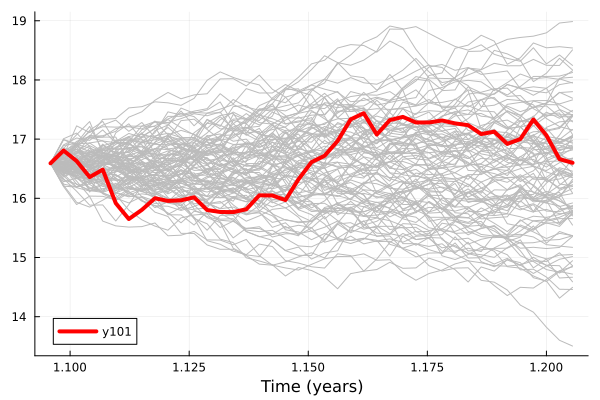

In [9]:
plot(X[:,1],X[:,2:end], label="", c=colors[7])
plot!(X[:,1], firm_data[start_index:stop_index, :volume_weighted_average_price], lw=4, c=:red)
xlabel!("Time (years)", fontsize=18)
ylabel!("Volume weighted average price (USD/share", fontsize=18)